# 시차상관분석
---

## 라이브러리 import

In [42]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics as st
from scipy.stats import gmean

# 경고 메세지 삭제
import warnings
warnings.filterwarnings('ignore')

# 한글 깨짐 방지
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

# 차트에 마이너스 출력
plt.rcParams['axes.unicode_minus'] = False

# 지수로 출력되는 값 없애기
pd.options.display.float_format = '{:.5f}'.format

## 등수 데이터 제작

In [28]:
# 60일 기준으로 슬라이스
import pandas as pd
import os

## 데이터를 불러올 경로지정
path = '../datasets/boxoffice/'

## 데이터 파일 리스트 생성
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.xlsx')]

## 영화이름 리스트 생성
a = []
for i in file_list_py:
    data = pd.read_excel(path + i)
    data["영화이름"] = i
    a.append(data)

## 슬라이스 하는 함수
def slice(df):
    df = df.iloc[0:60]
    df.reset_index(drop=True, inplace=True)
    return df

## 슬라이스, 저장 반복문
save_path = '../movie_rank/'   # 저장경로

for i in range(len(a)):
    a[i] = slice(a[i])
    filename = os.path.join(save_path, '{}등영화.csv'.format(str(i+1).zfill(3)))
    a[i].to_csv(filename, encoding='utf-8')

# 데이터 로드 및 개별 데이터프레임 생성

In [29]:
# 데이터를 받아올 경로 지정
path = '../movie_rank/'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')] # 경로안에서 .csv로 끝나는 파일들을 로드

# 데이터프레임 리스트 생성
movie = []
for i in file_list_py:
    data = pd.read_csv(path + i, index_col=0)
    movie.append(data)

# 하나의 리스트에 받아진 데이터들을 개별 데이터프레임으로 변환
for i in range(0, 100, 1):
    df_name = 'df' + str(i+1) 
    globals()[df_name] = pd.DataFrame(movie[i])

In [52]:
## 지수 데이터 로드
movie_index = pd.read_csv('../datasets/영화업종지수.csv')

## 시차상관분석 함수

In [44]:
# 영화문화지수와 비교

def change_movie(df, df2):
    # 영화데이터 날짜 컬럼 시계열로 변경
    df['날짜']= pd.to_datetime(df['날짜'])
    # 개별 영화 데이터에서 날짜와 관객수 추출
    df = df[['날짜','관객수']]
    # 인덱스 초기화
    df.reset_index(drop=True,inplace=True)

    # 영화업종지수 Date컬럼 시계열로 변경
    df2['일자'] = pd.to_datetime(df2['일자'])
    # 영화업종지수 데이터 중 '일자', '수정주가지수' 컬럼만 추출
    df2 = df2[['일자', '수정주가지수']]
    # 컬럼명 변경
    df2.columns = ['날짜', '수정주가지수']

    # 개별영화 + 영화업종지수 주식 컬럼 결합 ( a 함수를 사용하여 개별영화의 날짜(개봉일)를 기준으로 결합 )
    a = pd.merge(df, df2, how='left', on='날짜')
    # 결측치 = 선형 보간 ( interpolate() )
    a['수정주가지수'] = a['수정주가지수'].interpolate()
    # a = a.dropna()
    a = a.reset_index(drop='index')
    # a['시가 변화율'] = (a['시가'].pct_change().dropna()) * 100
    # a['누적관객수 변화율'] = (a['누적관객수'].pct_change().dropna()) * 100
    a.fillna(0, inplace=True) # 결측치 0으로 대체

    a = a.set_index('날짜')

    ## 여기서부터 시차상관계수 코드

    df_1 = np.array(a[['관객수']])
    df_2 = np.array(a[['수정주가지수']])

    cc = sm.tsa.stattools.ccf(df_1, df_2, adjusted=False, fft=True)
    return cc

## 시차상관분석함수를 활용해 플롯을 그리는 반복문 

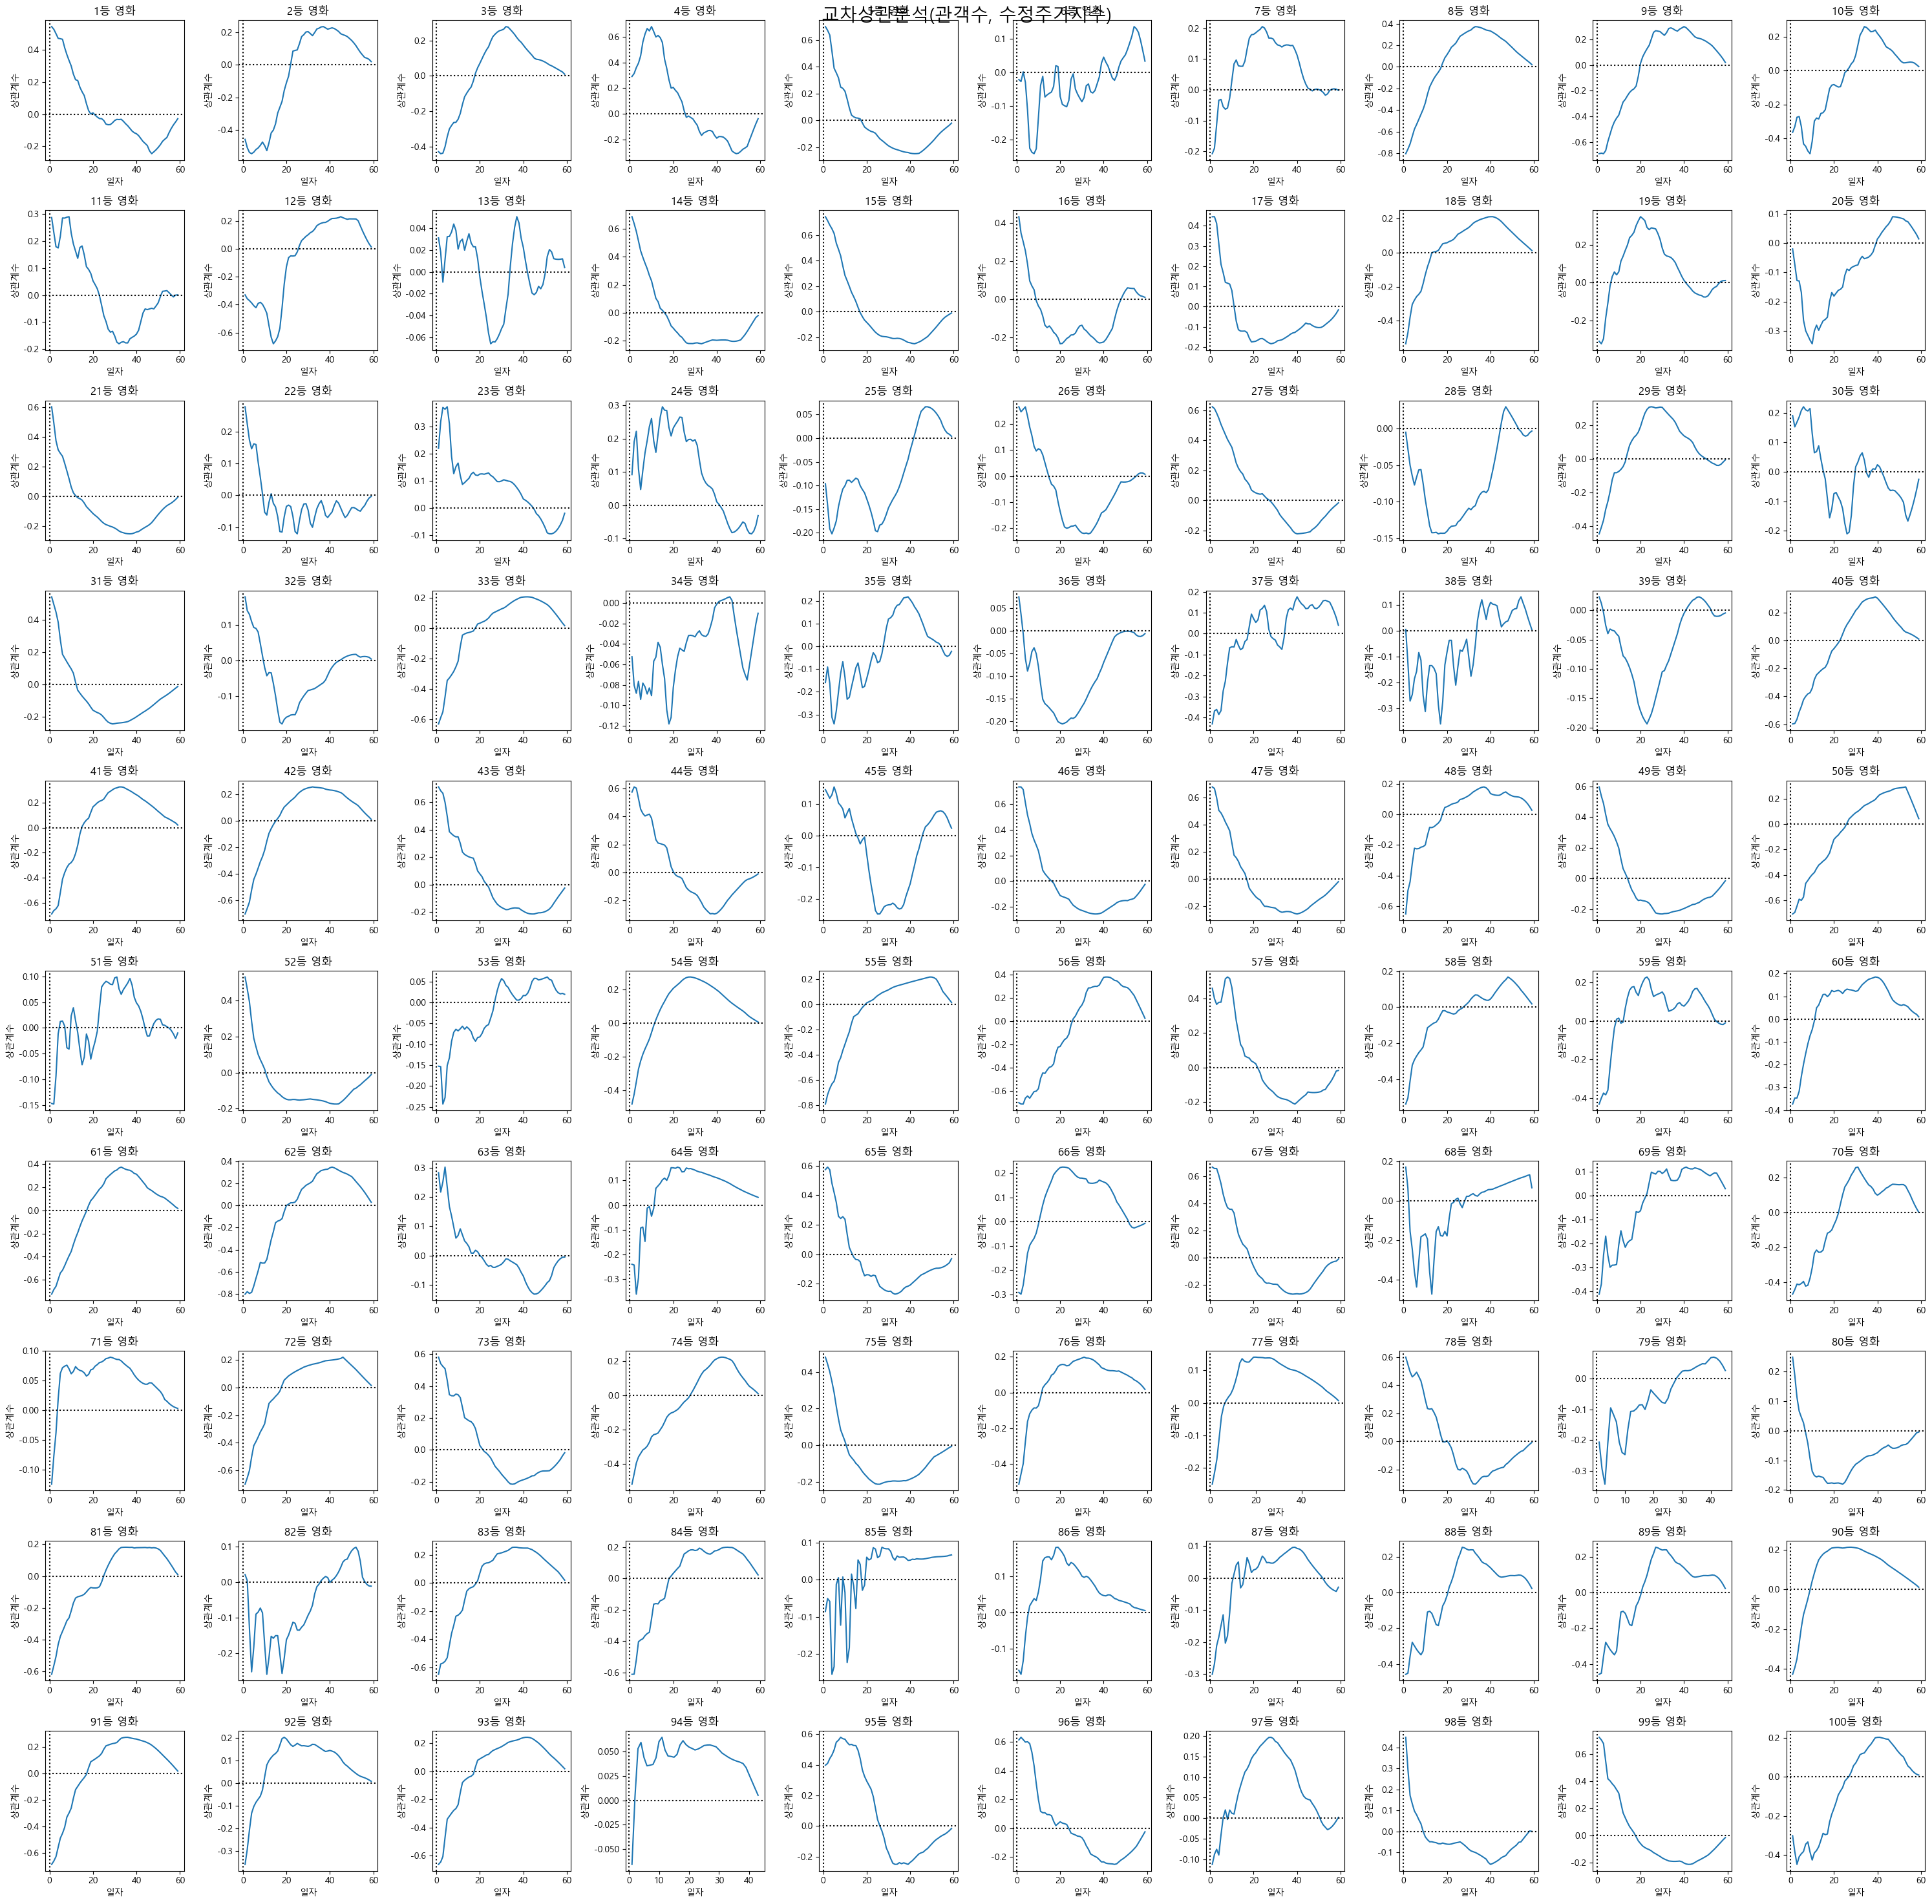

In [54]:
plt.figure(figsize=(30,30))
ls_cc = []
ls_cc_length = []

for i in range(100):
    cc = change_movie(movie[i], movie_index)
    ls_cc.append(cc)
    ls_cc_length.append(len(ls_cc[i]))
                        
    plt.subplot(10, 10, i+1)
    plt.plot(range(1, len(cc)), cc[1:60])
    plt.axvline(x=0, color='k' ,linestyle = ':')
    plt.axhline(y=0, color='k' ,linestyle = ':')
    plt.title('{}등 영화'.format(i+1))
    plt.xlabel('일자')
    plt.ylabel('상관계수')
    
plt.suptitle('교차상관분석(관객수, 수정주가지수)', fontsize=20)
plt.tight_layout()
plt.show()

In [55]:
## 에러데이터 확인(상영일이 60일이 되지 않는 영화)
error_data = []

for i in range(100):
    if (ls_cc_length[i] < 60):
        error_data.append(i)

error_data

[76, 78, 93]

# 투자시점 12일 기준 6일초과 공휴일인 영화 드랍

In [56]:
def drop_movie(df, df2):
    df = df.iloc[0:12]
    # 영화데이터 날짜 컬럼 시계열로 변경
    df['날짜']= pd.to_datetime(df['날짜'])
    # 개별 영화 데이터에서 날짜와 관객수 추출
    df = df[['날짜','관객수']]
    # 인덱스 초기화
    df.reset_index(drop=True,inplace=True)

    # 업종인덱스 주식 Date컬럼 시계열로 변경
    df2['일자'] = pd.to_datetime(df2['일자'])
    # 업종인덱스 데이터 중 '일자', '수정주가지수' 컬럼만 추출
    df2 = df2[['일자', '수정주가지수']]
    # 컬럼명 변경
    df2.columns = ['날짜', '수정주가지수']

    # 개별영화 + 업종인덱스 주식 컬럼 결합 ( a 함수를 사용하여 개별영화의 날짜(개봉일)를 기준으로 결합 )
    a = pd.merge(df, df2, how='left', on='날짜')
    ls = []
    if a['수정주가지수'].isna().sum() > 6:
        ls.append(1)
    else:
        ls.append(2)
    result = ls
    return result

In [57]:
# 12일 기준 6일 초과 공휴일인 영화 ls2 리스트화
ls2 = []

for i in movie:
    x = drop_movie(i, movie_index)
    ls2.append(x)

ls2 = pd.DataFrame(ls2)

In [58]:
# 12일 기준 6일 초과 공휴일인 영화확인
ls2[ls2[0] == 1]

,0
22,1
24,1
35,1
49,1
58,1
74,1
89,1
95,1


# 상관계수가 변하는 지점을 구하는 함수

* 상관계수가 음 -> 양 or 양 -> 음 으로 변하는 지점

In [59]:
def change_CC(df, df2):
    # 영화데이터 날짜 컬럼 시계열로 변경
    df['날짜']= pd.to_datetime(df['날짜'])
    # 개별 영화 데이터에서 날짜와 관객수 추출
    df = df[['날짜','관객수']]
    # 인덱스 초기화
    df.reset_index(drop=True,inplace=True)

    # 영화업종지수 Date컬럼 시계열로 변경
    df2['일자'] = pd.to_datetime(df2['일자'])
    # 영화업종지수 데이터 중 '일자', '수정주가지수' 컬럼만 추출
    df2 = df2[['일자', '수정주가지수']]
    # 컬럼명 변경
    df2.columns = ['날짜', '수정주가지수']

    # 개별영화 + 영화업종지수 주식 컬럼 결합 ( a 함수를 사용하여 개별영화의 날짜(개봉일)를 기준으로 결합 )
    a = pd.merge(df, df2, how='left', on='날짜')
    # 결측치 = 선형 보간 ( interpolate() )
    a['수정주가지수'] = a['수정주가지수'].interpolate()
    # a = a.dropna()
    a = a.reset_index(drop='index')
    # a['수정주가지수 변화율'] = (a['수정주가지수'].pct_change().dropna()) * 100
    # a['누적관객수 변화율'] = (a['누적관객수'].pct_change().dropna()) * 100
    a.fillna(0, inplace=True) # 결측치 0으로 대체

    a = a.set_index('날짜')

    ## 여기서부터 시차상관계수 코드

    df1 = np.array(a[['관객수']])
    df2 = np.array(a[['수정주가지수']])

    cc = sm.tsa.stattools.ccf(df1, df2, adjusted=False, fft=True)

    sign_change_points = []
    for i in range(1, len(cc)):
        if (cc[i-1] > 0 and cc[i] < 0) or (cc[i-1] < 0 and cc[i] > 0):
            sign_change_points.append(i)
    result = sign_change_points
    return result

In [60]:
# 상위 100개의 영화 중 상관계수가 0으로 수렴하는 날짜 change_point 리스트화

change_points = []

for i in range(100):
   x = change_CC(movie[i], movie_index)
   change_points.append(x)

change_points

[[21],
 [22],
 [18],
 [26],
 [18],
 [3, 4, 18, 20, 39, 44, 47],
 [10, 47, 48, 51, 56, 59],
 [18],
 [20],
 [26],
 [23, 52, 57, 59],
 [26],
 [1, 3, 4, 20, 34, 42, 51],
 [16],
 [17],
 [9, 49],
 [12],
 [14],
 [7, 41, 57],
 [1, 40],
 [13],
 [10, 13, 14],
 [45],
 [42],
 [42],
 [15, 55],
 [28],
 [1, 45, 53],
 [14, 51],
 [16, 30, 35, 37, 43],
 [13],
 [10, 45],
 [18],
 [41, 48],
 [28, 55],
 [3],
 [18, 28, 35],
 [2, 34],
 [3, 41, 53],
 [23],
 [15],
 [16],
 [24],
 [21],
 [16, 46],
 [17],
 [17],
 [18],
 [15],
 [26],
 [5, 8, 10, 13, 23, 44, 48, 55],
 [11],
 [27],
 [12],
 [20],
 [26],
 [22],
 [28],
 [9, 11, 13, 55],
 [12],
 [18],
 [21],
 [21],
 [12],
 [14],
 [11, 52],
 [19],
 [3, 24, 26, 29],
 [23],
 [23],
 [4],
 [18],
 [22],
 [28],
 [11],
 [12],
 [7],
 [18, 20, 21],
 [28],
 [7],
 [25],
 [3, 36, 40, 41, 57],
 [19],
 [19],
 [7, 8, 9, 10, 13, 14, 16, 18, 20],
 [6],
 [11, 14, 16, 52],
 [21],
 [21],
 [10],
 [18],
 [10],
 [18],
 [2],
 [27],
 [24],
 [6, 8, 9, 51, 59],
 [10, 58],
 [18],
 [27]]

In [61]:
# change_point 리스트를 데이터프레임으로 제작

df_change = pd.DataFrame(change_points)

In [62]:
# change_point 중 이상치 확인

def outliers_ipr(df, col):
    ## 1사분위수, 3사분위수 변수에 대입
    quartile_1, quartile_3 = np.percentile(df[col], [25, 75]) # np.percentile은 영상의 intensity 중 분위수를 구해주는 함수
    ## iqr 값을 대입
    iqr = quartile_3 - quartile_1
    ## 하단 경계 값, 상단 경계 값
    lower_whis = quartile_1 - (1.5 * iqr)
    upper_whis = quartile_3 + (1.5 * iqr)
    print(lower_whis, upper_whis)
    ## 데이터프레임에서 상단 경계보다 크거나 하단의 경계보다 작은 데이터를 출력
    outliers = df[(df[col] > upper_whis) | (df[col] < lower_whis)]
    return outliers[[col]]


In [63]:
# 이상치 제거

a = outliers_ipr(df_change, 0)

drop_outliers = df_change.drop(a.index)
drop_outliers
# df_change.drop()

-8.0 40.0


,0,1,2,3,4,5,6,7,8
0,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
95,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,6,8.00000,9.00000,51.00000,59.00000,NaN,NaN,NaN,NaN
97,10,58.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# 이상치 제거가 된 날짜들의 기하평균 구하기

df_change_ls = []
df_change_ls = drop_outliers[0]

# 조화평균
# st.harmonic_mean(list(df_change_ls))

# 기하평균 (과거 수익률 평가 시 기하평균 필요)
gmean(list(df_change_ls))

12.731952486308922

In [65]:
# 이상치 제거가 된 날짜들의 기하평균 구하기

df_change_ls = []
df_change_ls = drop_outliers[1]

# 조화평균
# st.harmonic_mean(list(df_change_ls))

# 기하평균 (과거 수익률 평가 시 기하평균 필요)
gmean(list(df_change_ls))

nan

In [66]:
ls = drop_outliers[1]

In [67]:
ls.value_counts()

8.00000     3
52.00000    2
41.00000    2
55.00000    2
45.00000    2
4.00000     1
34.00000    1
14.00000    1
36.00000    1
20.00000    1
24.00000    1
11.00000    1
46.00000    1
30.00000    1
28.00000    1
47.00000    1
51.00000    1
13.00000    1
40.00000    1
49.00000    1
3.00000     1
58.00000    1
Name: 1, dtype: int64

In [68]:
gmean(ls.dropna())

25.380598307713136

In [69]:
# 영화 별 상관계수가 0으로 바뀌게 된 첫번째 날짜 확인

df_change[0].sort_values(ascending=False)

22    45
24    42
23    42
33    41
34    28
      ..
93     2
37     2
12     1
27     1
19     1
Name: 0, Length: 100, dtype: int64